# 単回帰分析

In [1]:
import numpy as np
import pandas as pd
import wooldridge
import statsmodels.formula.api as smf
import py4macro

## 回帰分析：復習

**母集団回帰式**

データを生成する式（観測できない）と考えよう。

$$y=\beta_0+\beta_1 x + u$$

* $\beta_0$：定数項（真の値）
* $\beta_1$：スロープ係数（真の値）
* $y$： 被説明変数
* $x$： 説明変数
* $u$： 誤差項（errors)
    * 平均はゼロと仮定する

**標本**

* 大きさ$n$の無作為標本を取る。

    $$(y_i,x_i),\quad i=1,2,3...n$$

* 母集団からの標本は次式を満たす。

    $$y_i=\beta_0+\beta_1 x_i + u_i,\quad i=1,2,..n$$
    
    * $\beta_0,\;\beta_1\;u_i$は観測不可能

**最小二乗法法（Ordinary Least Squares; OLS）**

$$\sum_{i=1}^n\left(y_i-\beta_0-\beta_1 x_i\right)^2$$

を最小化する$\beta_0$と$\beta_1$を選択する。最小化の一階条件：

$$
\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x},\qquad\qquad
\hat{\beta}_1=\frac{\text{Cov}(x,y)}{\text{Var}(x)}
$$

* $x$のように添え字$i$を省いた場合は，$x_1$から$x_n$までの全ての観測値という意味（$y$も同じ）
* `^`（ハット）がある変数（$\hat{\beta}_0$と$\hat{\beta}_1$）を**OLS推定量**と呼ぶ
* `-`（バー）がある変数（例えば，$\bar{y}$）は平均値
* $\text{Cov}(x,y)=$ $x$と$y$の共分散
* $\text{Var}(x)=$ $x$の分散

* 次式が成立する。

    $$y_i=\hat{\beta}_0+\hat{\beta}_1 x_i + \hat{u}_i$$
    
    * $\hat{u}_i$：残差
    * 予測値 $\hat{y}_i$

$$\hat{y}_i=\hat{\beta}_0 + \hat{\beta}_1x_i$$

$$\hat{u}_i=y_i-\hat{y}_i$$

## データ

`wooldridge`のパッケージに含まれるデータを使う。使う関数は`data()`であり，引数なしで実行するとデータセットのリストが表示される。

In [2]:
wooldridge.data()

  J.M. Wooldridge (2016) Introductory Econometrics: A Modern Approach,
  Cengage Learning, 6th edition.

  401k       401ksubs    admnrev       affairs     airfare
  alcohol    apple       approval      athlet1     athlet2
  attend     audit       barium        beauty      benefits
  beveridge  big9salary  bwght         bwght2      campus
  card       catholic    cement        census2000  ceosal1
  ceosal2    charity     consump       corn        countymurders
  cps78_85   cps91       crime1        crime2      crime3
  crime4     discrim     driving       earns       econmath
  elem94_95  engin       expendshares  ezanders    ezunem
  fair       fertil1     fertil2       fertil3     fish
  fringe     gpa1        gpa2          gpa3        happiness
  hprice1    hprice2     hprice3       hseinv      htv
  infmrt     injury      intdef        intqrt      inven
  jtrain     jtrain2     jtrain3       kielmc      lawsch85
  loanapp    lowbrth     mathpnl       meap00_01   meap01
  meap93    

この中にある`wage1`を使う。

In [3]:
df = wooldridge.data('wage1')

オプション`description=True`を追加するとデータの説明を表示することができる。

In [4]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

> 教育水準は賃金にどのような影響を与えるのか

* 被説明変数：`wage`（平均時給、単位：米ドル）
* 説明変数：`educ`（教育年数、単位：年）

まず関係する変数だけを取り出してみる。

In [5]:
df = df.loc[:,['wage','educ']]

最初の3行の表示をしてみよう。


In [6]:
df.head(3)

,wage,educ
0,3.10,11
1,3.24,12
2,3.00,11


`DataFrame`の特徴を確認する。

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    526 non-null    float64
 1   educ    526 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 8.3 KB


記述統計

In [8]:
df.describe()

,wage,educ
count,526.000000,526.000000
mean,5.896103,12.562738
std,3.693086,2.769022
min,0.530000,0.000000
25%,3.330000,12.000000
50%,4.650000,12.000000
75%,6.880000,14.000000
max,24.980000,18.000000


## 「手計算」

上で示した$\hat{\beta}_0$と$\hat{\beta}_1$の式を使い係数の推定値を計算する。まず分散共分散行列を計算する。

In [9]:
mat_wage_educ = np.cov(df['wage'],df['educ'])
mat_wage_educ

array([[13.63888436,  4.150864  ],
       [ 4.150864  ,  7.66748506]])

共分散の値を`cov_wage_edu`に割り当てる。

In [10]:
cov_wage_educ = mat_wage_educ[0, 1]
cov_wage_educ

4.150863998572982

`wage`と`educ`の分散は次のコードで取得できる。

In [11]:
var_educ = mat_wage_educ[1,1]

上の式に従って$\beta_1$の推定値 $\left(\hat{\beta}_1\right)$を計算する。

In [12]:
b1hat = cov_wage_educ / var_educ
b1hat

0.5413592546651748

**＜結果の解釈＞**

`b1hat`は次式の推定結果である。

$$y = \beta_0+\beta_1x+u$$

$x$について微分すると

$$
\dfrac{dy}{dx}=\dfrac{y\text{の変化}}{x\text{の増加}}
=
\left(
\begin{array}{l}
    x\text{が1単位増加した}\\
    \text{場合の}yの\text{変化}
    \phantom{春}
\end{array}
\right)
=\beta_1
$$

OLS推定結果は教育年数が１年増えると賃金は約0.54ドル上昇することを示している。

同様に$\beta_0$の推定値 $\left(\hat{\beta}_0\right)$も計算する。まずそれぞれの変数の平均を計算する。

In [13]:
mean_wage = df['wage'].mean()
mean_educ = df['educ'].mean()

In [14]:
b0hat = mean_wage - b1hat * mean_educ
b0hat

-0.9048516119572136

## `statsmodels`を使う

`statsmodels`を次の順番で使い方を説明する。
* `ols`サブパッケージを読み込む
* 回帰式を定義する
* 推定値の自動計算

**Step 1: サブパッケージの読み込み**

`statsmodels`には多くのサブパッケージや関数があり、回帰分析をおこなう際に色々なコードの書き方がある。ここでは最も直感的な書き方を説明する。冒頭で次のコードでインポートされている。
```
import statsmodels.formula.api as smf
```
`smf`に含まれる関数`ols`を使い計算する。

**Step 2: 回帰式の定義**

* 式を`''`で囲む（文字列）
* 定数項である（$\beta_0$）は自動的に挿入される。

```
被説明変数 ~ 説明変数
```
---
`wage`を被説明変数にし，定数項を加えて`educ`を説明変数をする場合，次のように書くことになる。

In [15]:
formula = 'wage ~ educ'

**Step 3: 自動計算**

* 自動計算の準備として計算の対象となるもの（インスタンスと呼ばれるオブジェクト）を生成し、変数`mod`（"model"の省略形）に割り当てる。
* 第１引数は上で定義した回帰式，第２引数`data`は使用するデータをを指定する。

In [16]:
mod = smf.ols(formula, data=df)

`mod`の属性を調べてみよう。

In [17]:
see(mod)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .data
    .df_model          .df_resid          .endog             .endog_names
    .exog              .exog_names        .fit()
    .fit_regularized()                    .formula           .from_formula()
    .get_distribution()                   .hessian()         .hessian_factor()
    .information()     .initialize()      .k_constant        .loglike()
    .nobs              .predict()         .rank              .score()
    .weights           .wendog            .wexog             .whiten()

* OLS関連の計算を一瞬で実行するメソッド`fit()`が準備されている。
* 結果を`res`に割り当てる（`res`はresultの略）。

In [29]:
res = mod.fit()

上の２つを分けずに一行で書いても良い。
```
res = smf.ols(formula, data=df).fit()
```
`res`の属性を確認してみよう。

In [30]:
see(res)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .eigenvals           .el_test()
    .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .info_criteria()     .initialize()        .k_constant          .llf
    .load()              .model               .mse_mod

上のリストの中に`.params`とあるが，この属性を使い係数の推定値を取り出すことができる。

In [20]:
res.params

Intercept   -0.904852
educ         0.541359
dtype: float64

* メソッド`summary()`を使うと主な結果がまとめられた表を出力する。

In [21]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     103.4
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           2.78e-22
Time:                        12:55:11   Log-Likelihood:                -1385.7
No. Observations:                 526   AIC:                             2775.
Df Residuals:                     524   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.1

上の表は３つの表から構成されており，必要な部分だけを表示することも可能である。
```
res.summary().tables[0]
res.summary().tables[1]
res.summary().tables[2]
```
例えば，係数の推定値に関する基本的な統計量だけを表示するには以下のようにすれば良い。

In [22]:
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.187      -2.250       0.441
educ           0.5414      0.053     10.167      0.000       0.437       0.646


**＜表の説明＞**

表は3つのセクションから構成されている。
* 上段にはOLS推定の基本的な情報が表示されている。
    * 左側
        * `Dep. Variable`：被説明変数
        * `Model`：モデル
        * `Method`：手法
        * `Data`：日にち
        * `Time`：時間
        * `No. Observation`：標本の大きさ
        * `Df Residuals`：残差の自由度
        * `Df Model`：モデルの自由度（定数項以外の説明変数の数）
        * `Covariance Type`：共分散のタイプ
    * 右側
        * `R-squared`：決定係数
        * `adj. R-squared`：自由度調整済み決定係数
        * `F-statistic`：$F$統計量
        * `Prob (F-statistic)`：$F$値
        * `Log-Likelihood`：対数尤度
        * `AIC`：赤池情報量規準
        * `BIC`：ベイズ情報量規準
* 中段には主な推定結果が表示される。
    * 列ラベル
        * `coef`：係数
        * `std err`：標準誤差
        * `t`：$t$値
        * `P>|t|`：$p$値
        * `[0.025,0.975]`：信頼区間（5%)
    * 行ラベル
        * `Intercept`：定数項
        * `tfp_relative`：説明変数（選択する変数によって変わる）
* 下段には様々な検定などに関する数値が並んでいる。
    * 左側
        * `Omnibus`：オムニバス検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(Omnibus)`：オムニバス検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Skew`：残差の歪度（正規分布であれば`0`）
        * `Kurtosis`：残差の尖度（正規分布であれば`3`）
    * 右側
        * `Durbin-Watson`：ダービン・ワトソン統計量（残差の自己相関の検定）
        * `Jarque-Bera (JB)`：ジャーク・ベラ検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(JB)`：ジャーク・ベラ検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Cond. No.`：条件指数（Condition Index）の最大値（多重共線性を確認するための指標であり，単回帰分析では無視して良い。）

主な属性とメソッド：
* `nobs`：標本の大きさ（Number of OBservationS）
* `params`：推定値（PARAMeterS）
* `bse`：推定値の標準誤差（Standard Errors）
* `tvalues`：推定値の$t$値（T VALUES）
* `pvalues`：推定値の$p$値（P VALUES）
* `rsquared`：決定係数（R SQUARED）
* `rsquared_adj`：自由度調整ずみ決定係数（ADJusted R SQUARED）
* `conf_int()`：95%信頼区間（CONFidence INTerval）
* `fittedvalues`：予測値（$\hat{y}$）（FITTED VALUES）
* `resid`：残差（$\hat{u}$）（RESIDuals）

## 図示

回帰分析の結果を図示するために、まず予測値の取得する。

In [23]:
wage_hat = res.fittedvalues

データの散布図と回帰直線を図示する。

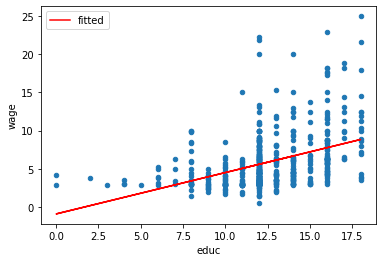

In [24]:
df['fitted'] = res.fittedvalues
ax_ = df.plot(x='educ',y='wage', kind='scatter')
df.plot(x='educ',y='fitted', ax=ax_, color='r')
pass

## 賃金の対数化

* 上の回帰分析の問題：定数項の値は`0`
* 賃金と教育年数は非線形の関係が成り立つのでは？
* 労働経済学では賃金の対数をとり推定するのが一般的であり、そのような式を賃金方程式と呼ぶ。

In [25]:
df['wage_log'] = np.log(df['wage'])

In [26]:
formula = 'wage_log ~ educ'

In [27]:
res_log = smf.ols(formula, data=df).fit()

In [28]:
print(res_log.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.097      5.998      0.000       0.393       0.775
educ           0.0827      0.008     10.935      0.000       0.068       0.098


**＜結果の解釈＞**

`res`は次式の推定結果である。

$$\ln y = \beta_0+\beta_1x+u$$

$x$について微分すると

$$\dfrac{d\ln y}{dx}=\dfrac{dy/y}{dx}=\dfrac{y\text{の%変化}}{dx}=\beta_1$$

* OLS推定結果は教育年数が１年増えると賃金は約8.3%増加することを示している。
* この値は教育の収益率である。

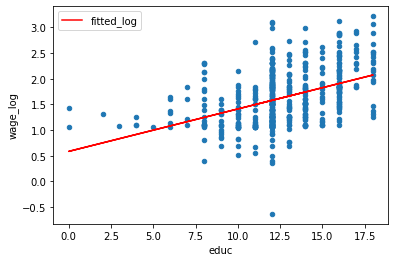

In [29]:
# 散布図と回帰曲線
df['fitted_log'] = res_log.fittedvalues
ax_ = df.plot(x='educ',y='wage_log', kind='scatter')
df.plot(x='educ',y='fitted_log', ax=ax_, color='r')
pass